# MiniProyecto 4: Optimización de parámetros

¡Bienvenidos al cuarto (mini)proyecto de la carrera de Data Science de Acamica! 

En este proyecto vamos a seguir trabajando (por última vez) con el dataset de propiedades en venta publicadas en el portal [Properati](www.properati.com.ar). El objetivo en este caso es optimizar los parámetros de los algoritmos que usamos en el proyecto pasado.

El dataset es el mismo del proyecto 3. Recordemos que las columnas que se agregan son:

* `barrios_match`: si coincide el barrio publicado con el geográfico vale 1, si no 0.

* `PH`, `apartment`, `house`: variables binarias que indican el tipo de propiedad.

* dummies de barrios: variables binarias con 1 o 0 según el barrio.

La métrica que vamos a usar para medir es RMSE (raíz del error cuadréatico medio), cuya fórmula es:

$$RMSE = \sqrt{\frac{\sum_{t=1}^n (\hat y_t - y_t)^2}{n}}$$

## Pandas - Levantamos el dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
np.random.seed(123)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

pd.set_option('display.float_format', lambda x: '%.3f' % x)
path_dataset = 'dataset/datos_properati_limpios_model.csv'
df = pd.read_csv(path_dataset)
df.head()

,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,barrio_match,PH,apartment,house,...,VILLA LUGANO,VILLA LURO,VILLA ORTUZAR,VILLA PUEYRREDON,VILLA REAL,VILLA RIACHUELO,VILLA SANTA RITA,VILLA SOLDATI,VILLA URQUIZA,outlier_price_m2
0,-34.589,-58.417,170000.000,40.000,38.000,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,-34.591,-58.418,90000.000,27.000,27.000,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-34.587,-58.437,150000.000,44.000,44.000,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,-34.593,-58.428,154000.000,58.000,58.000,2,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,-34.593,-58.428,154000.000,58.000,58.000,3,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


**Separá** el dataset en entrenamiento (80%) y test (20%) utilizando como target la columna `price_aprox_usd`

In [2]:
X = df.drop(['price_aprox_usd'], axis=1)
y = df['price_aprox_usd']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print(f"El dataset de entrenamiento se compone de {X_train.shape[0]} observaciones.\nEl dataset de testeo se compone de {X_test.shape[0]}.")

El dataset de entrenamiento se compone de 5100 observaciones.
El dataset de testeo se compone de 1276.


## Scikit-learn - Entrenamiento

Para repasar los parámetros de árboles de decisión en Scikit-learn: 

http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html

En primer lugar veamos como hacer cross validation. Para eso necesitamos definir la cantidad de folds, en este caso vamos a usar 5.

GridSearchCV nos permite testear a través de un espacio de búsqueda de parámetros la mejor combinación posible dado un estimador.

Por ejemplo, en este caso probamos la profundidad máxima y la máxima cantidad de features para hacer los split. Ambos entre 1 y 5.
Recordemos que para hacer la optimización scikit-learn usa la métrica `neg_mean_squared_error` en lugar de `mean_squared_error`.

**Creá** una variable `param_grid` con valores del 1 al 5 para los atributos `max_depth` y `max_features`. 

In [3]:
param_grid = [{'max_depth':[1,2,3,4,5],'max_features':[1,2,3,4,5]}]
param_grid

[{'max_depth': [1, 2, 3, 4, 5], 'max_features': [1, 2, 3, 4, 5]}]

**Creá** una variable `grid_search` y asignale un `GridSearchCV` que recorra el `param_grid` que creaste con el algoritmos `DecisionTreeRegressor` y el un scoring de `neg_mean_squared_error`

In [4]:
tree_reg = DecisionTreeRegressor(random_state = 0)
grid_search = GridSearchCV(estimator=tree_reg, param_grid = param_grid, cv = 5, 
                           scoring = 'neg_mean_squared_error', return_train_score=True)

A continuación, realizá el `fit` del `grid_search` con el conjunto de entrenamiento

In [5]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=0,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid=[{'max_depth': [1, 2, 3, 4, 5],
                          'max_features': [1, 2, 3, 4, 5]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='n

Revisemos los resultados. Recordemos que no están expresados en RMSE.

**Mostrá** los `grid_scores` obtenidos durante el `grid_search`

In [6]:
grid_scores = pd.DataFrame(grid_search.cv_results_['params'])
grid_scores['neg_mean_train_score'] = grid_search.cv_results_['mean_train_score']
grid_scores['neg_mean_test_score'] = grid_search.cv_results_['mean_test_score']
grid_scores.head()

,max_depth,max_features,neg_mean_train_score,neg_mean_test_score
0,1,1,-979014205.942,-979790172.137
1,1,2,-978511586.894,-979795655.597
2,1,3,-967114860.993,-967431345.965
3,1,4,-967114860.993,-967431345.965
4,1,5,-967114860.993,-967431345.965


De esta manera, el valor con mejor resultado (dado el espacio de búsqueda definido) es `max_depth` 3 y `max_features` 3.

**Mostrá** el mejor score y los mejores parámetros encontrados por `grid_search`

In [7]:
print(f"Mejor score: {round(grid_search.best_score_,2)}")

depth = grid_search.best_params_['max_depth']
features = grid_search.best_params_['max_features']
print(f"Los mejores parámetros:\n  depth: {depth}\n  features: {features}\n ")

Mejor score: -729969370.34
Los mejores parámetros:
  depth: 3
  features: 3
 


Convertimos a RMSE.

In [8]:
def nmsq2rmse(score):
    return np.round(np.sqrt(-score), 2)

grid_scores['root_mean_train_score'] = grid_scores['neg_mean_train_score'].apply(lambda x: nmsq2rmse(x))
grid_scores['root_mean_test_score'] = grid_scores['neg_mean_test_score'].apply(lambda x: nmsq2rmse(x))
grid_scores.drop(['neg_mean_train_score', 'neg_mean_test_score'],axis=1,inplace =True)
grid_scores.head()

,max_depth,max_features,root_mean_train_score,root_mean_test_score
0,1,1,31289.200,31301.600
1,1,2,31281.170,31301.690
2,1,3,31098.470,31103.560
3,1,4,31098.470,31103.560
4,1,5,31098.470,31103.560


Validemos gráficamente que el mínimo se encuentra en `max_depth` 3 y `max_features` 3.

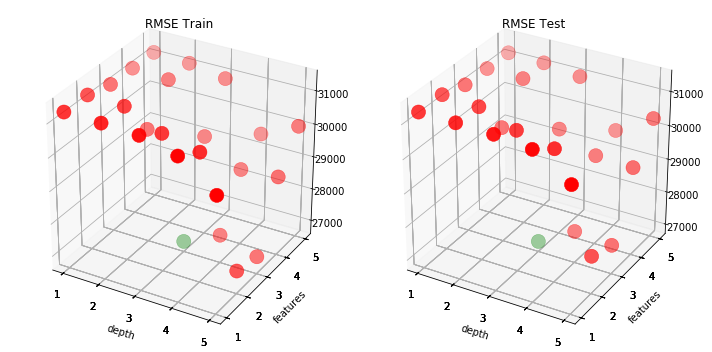

In [9]:
x = np.array(grid_scores['max_depth'])
y = np.array(grid_scores['max_features'])
z1 = grid_scores['root_mean_train_score']
z2 = grid_scores['root_mean_test_score']


# Se crea una máscara para diferenciar el mínimo con el color verde
zmin1 = np.min(z1)
mask1 = np.array(z1) == zmin1
color1 = np.where(mask1, 'green', 'red')
zmin2 = np.min(z2)
mask2 = np.array(z2) == zmin2
color2 = np.where(mask2, 'green', 'red')


# Inicializamos dos gráficos 3D
fig = plt.figure(figsize=(10,5))


ax1 = fig.add_subplot(1, 2, 1,projection='3d',xticks=x,yticks=y,title="RMSE Train",xlabel="depth", ylabel="features")
ax1.scatter(x, y, z1, c=color1, cmap='viridis', linewidth=0.5, s=200)

ax = fig.add_subplot(1, 2, 2,projection='3d',sharex=ax1,sharey=ax1,title="RMSE Test",xlabel="depth",ylabel="features")
ax.scatter(x, y, z2, c=color2, cmap='viridis', linewidth=0.5, s=200)

plt.tight_layout()
plt.show()

Se aprecia entonces que el mínimo del error de entrenamiento y validación se encuentra en `max_depth` 3 y `max_features` 3.

Recordemos que `GridSearchCV` tiene como parámetro default `refit=True`. Esto significa que luego de hacer la corrida se ajusta el mejor modelo al conjunto de datos de entrada. De esta manera, se puede predecir directamente usando `best_estimator_`.

In [10]:
optimised_decision_tree = grid_search.best_estimator_

__Evaluemos en testing el desempeño de este modelo.__

Como venimos trabajando, el resultado en testing será la medición que usaremos como benchmark para comparar este modelos con otros en el futuro, puesto que no estuvo en contacto con el dataset de test para la calibración.

In [11]:
y_opt_pred = optimised_decision_tree.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_opt_pred))
np.round(rmse)

25820.0

Vemos los primeros 10 resultados de la predicción del valor de propiedades.

In [12]:
val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_opt_pred)

In [13]:
predicciones1 = pd.concat([val_real.rename('Valor real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Dif(+/-)')] ,  axis=1)

In [14]:
predicciones1.head(10)

,Valor real,Valor Pred,Dif(+/-)
0,80000.000,98157.836,18157.836
1,128000.000,131079.617,3079.617
2,150000.000,131079.617,18920.383
3,85000.000,131079.617,46079.617
4,135000.000,133881.445,1118.555
5,135000.000,98157.836,36842.164
6,68000.000,131079.617,63079.617
7,110000.000,131079.617,21079.617
8,134000.000,131079.617,2920.383
9,110000.000,98157.836,11842.164


__Encontrar el mejor modelo para el espacio de búsqueda dado__

* `"min_samples_split": [2, 10, 20]`
* `"max_depth": [None, 2, 5, 10, 15]`
* `"min_samples_leaf": [1, 5, 10, 15]`
* `"max_leaf_nodes": [None, 5, 10, 20]`

In [15]:
param_grid = [{"min_samples_split": [2, 10, 20],
               "max_depth": [None, 2, 5, 10, 15],
               "min_samples_leaf": [1, 5, 10, 15],
               "max_leaf_nodes": [None, 5, 10, 20]}]

tree_reg = DecisionTreeRegressor(random_state = 0)
grid_search = GridSearchCV(estimator=tree_reg, param_grid = param_grid, cv = 5,
                           scoring = 'neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=0,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid=[{'max_depth': [None, 2, 5, 10, 15],
                          'max_leaf_nodes': [None, 5, 10, 20],
                          'min_samples_leaf': [1, 5, 10, 15],
                          'mi

In [16]:
grid_scores = pd.DataFrame(grid_search.cv_results_['params']).replace(np.NaN,0)
grid_scores['neg_mean_train_score'] = grid_search.cv_results_['mean_train_score']
grid_scores['neg_mean_test_score'] = grid_search.cv_results_['mean_test_score']

grid_scores['root_mean_train_score'] = grid_scores['neg_mean_train_score'].apply(lambda x: nmsq2rmse(x))
grid_scores['root_mean_test_score'] = grid_scores['neg_mean_test_score'].apply(lambda x: nmsq2rmse(x))
grid_scores.drop(['neg_mean_train_score', 'neg_mean_test_score'],axis=1,inplace =True)
grid_scores.head()

,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,root_mean_train_score,root_mean_test_score
0,0.000,0.000,1,2,465.640,26087.160
1,0.000,0.000,1,10,10776.610,24329.700
2,0.000,0.000,1,20,14114.660,23128.240
3,0.000,0.000,5,2,13826.680,22983.780
4,0.000,0.000,5,10,13826.680,22983.780


En este caso se cuenta con un espectro más amplio de parámetros, por lo que se dificulta intuir gráficamente los mejores parámetros.

In [17]:
grid_search.best_params_

{'max_depth': 10,
 'max_leaf_nodes': None,
 'min_samples_leaf': 15,
 'min_samples_split': 2}

In [18]:
depth = grid_search.best_params_['max_depth']
min_samples_leaf = grid_search.best_params_['min_samples_leaf']
min_samples_split = grid_search.best_params_['min_samples_split']

grid_scores[(grid_scores['max_depth'] == depth) & 
            (grid_scores['min_samples_leaf']== min_samples_leaf) & 
            (grid_scores['min_samples_split']== min_samples_split)]

,max_depth,max_leaf_nodes,min_samples_leaf,min_samples_split,root_mean_train_score,root_mean_test_score
153,10.000,0.000,15,2,18259.080,21433.800
165,10.000,5.000,15,2,24402.050,24600.040
177,10.000,10.000,15,2,22506.560,22855.360
189,10.000,20.000,15,2,21373.650,22046.430


Hagamos una predicción usando directamente `best_estimator_`.

In [19]:
optimised_decision_tree = grid_search.best_estimator_

__Evaluemos en testing el desempeño de este modelo.__

Como venimos trabajando, el resultado en testing será la medición que usaremos como benchmark para comparar este modelos con otros en el futuro, puesto que no estuvo en contacto con el dataset de test para la calibración.

In [20]:
y_opt_pred = optimised_decision_tree.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_opt_pred))
np.round(rmse)

21301.0

Se aprecia un menor error error cuadrático medio.
Vemos los primeros 10 resultados de la predicción del valor de propiedades.

In [21]:
val_real = pd.Series(y_test.values)
val_pred = pd.Series(y_opt_pred)

In [22]:
predicciones2 = pd.concat([val_real.rename('Valor real'),val_pred.rename('Valor Pred') ,abs(val_real-val_pred).rename('Dif(+/-)')] ,  axis=1)

In [23]:
predicciones1.describe()

,Valor real,Valor Pred,Dif(+/-)
count,1276.000,1276.000,1276.000
mean,120274.118,120815.251,21230.034
std,31502.692,16009.043,14701.541
min,60529.000,98157.836,79.617
25%,94000.000,98157.836,9157.836
50%,120000.000,131079.617,18920.383
75%,146000.000,131079.617,31079.617
max,179990.000,161200.000,76842.164


__Apreciemos gráficamente las diferencias en las predicciones para ambos árboles.__

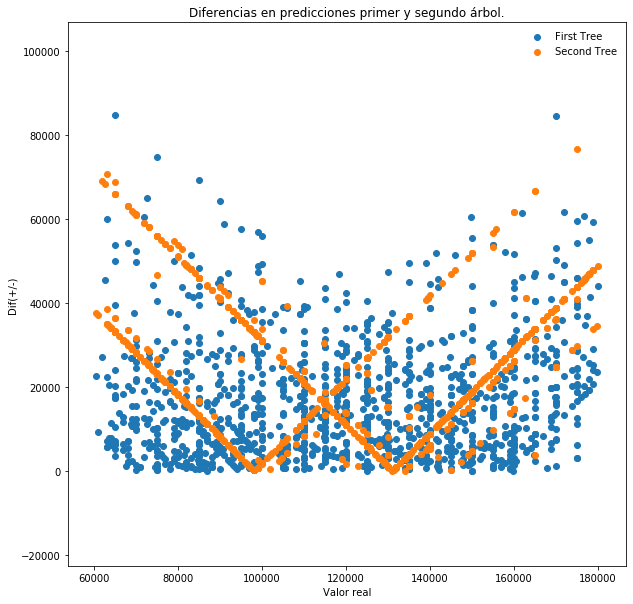

In [24]:
x = list(predicciones2.sort_values(by='Valor real')['Valor real'])
y = list(predicciones2.sort_values(by='Valor real')['Dif(+/-)'])
y2 = list(predicciones1.sort_values(by='Valor real')['Dif(+/-)'])
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x,y, label="First Tree")
ax.scatter(x,y2, label = "Second Tree")
plt.xlabel('Valor real')
plt.ylabel('Dif(+/-)')
ax.axis('equal')
ax.legend(frameon= False)
plt.title("Diferencias en predicciones primer y segundo árbol.")
plt.show()

Se aprecia entonces que el segundo árbol predice valores con menor diferencia respecto al valor real. Su mejor rendimiento se encuentra en el intervalo `_USD100,000 - USD130,000_`.